<a href="https://colab.research.google.com/github/BenYavor/MA_GAN/blob/master/MINE_Mutual_Information_Neural_Estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow==2.0.0-beta1

import sys
assert sys.version_info >= (3, 5)
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow_probability as tfp
import time

np.random.seed(42)
tf.random.set_seed(42)


In [0]:
#leaky_relu = tf.keras.layers.LeakyReLU()
randN_05 = keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
dim_n = 3 # Dim 4+ needs considerable fine-tuning

k = 2

M = 2**k

[<tf.Tensor 'input_1:0' shape=(None, 6) dtype=float32>, <tf.Tensor 'input_2:0' shape=(None, 6) dtype=float32>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            1171        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________

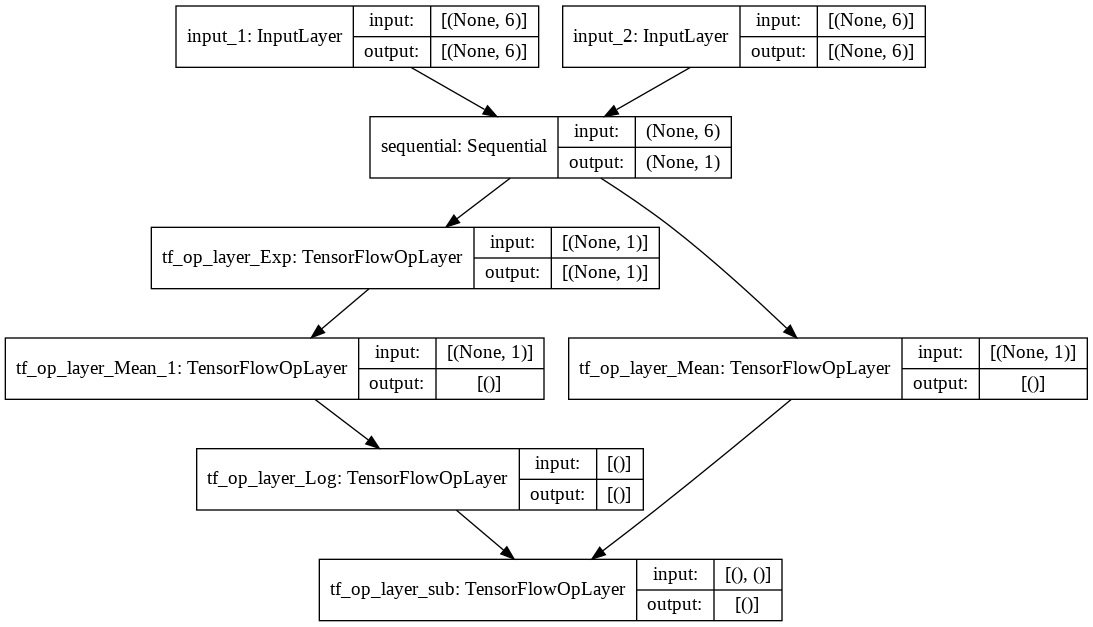

In [3]:
input_A = keras.layers.Input(shape=[2*dim_n])
input_B = keras.layers.Input(shape=[2*dim_n])
    
transform = keras.models.Sequential([
layers.Dense(30, kernel_initializer=randN_05, activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(30, kernel_initializer=randN_05, activation="relu"),
keras.layers.Dropout(rate=0.3), # To regularize higher dimensionality
layers.Dense(1, kernel_initializer=randN_05, activation=None)])

output_A = transform(input_A)
output_B = transform(input_B)
output_C = tf.reduce_mean(output_A) - tf.math.log(tf.reduce_mean(tf.exp(output_B))) # MINE
#output_C = tf.reduce_mean(output_A) - tf.reduce_mean(tf.exp(output_B))+1 # MINE-f
MI_mod = keras.Model(inputs=[input_A, input_B], outputs=output_C)

print(MI_mod.inputs)
MI_mod.summary()
keras.utils.plot_model(MI_mod, 'Structure_of_MI_estimation.png', show_shapes=True)


In [0]:
def loss_func(inp, outp):
  return -outp
    #'''Calculate the loss: scaled negative estimated mutual information'''
    

In [0]:
MI_mod.compile( loss= loss_func, optimizer=tf.keras.optimizers.Nadam(lr=0.001))

In [6]:
SIGNAL_NOISE = 0.2
SAMPLE_SIZE = dim_n*6000
SIGNAL_POWER = 3

x_sample = np.random.normal(0., np.sqrt(SIGNAL_POWER), [SAMPLE_SIZE, dim_n])
y_sample = x_sample + np.random.normal(0., np.sqrt(SIGNAL_NOISE), [SAMPLE_SIZE, dim_n])

x_sample1, x_sample2 = tf.split(x_sample, num_or_size_splits=2)
y_sample1, y_sample2 = tf.split(y_sample, num_or_size_splits=2)
joint_sample = tf.concat([x_sample1, y_sample1], axis=1)
marg_sample = tf.concat([x_sample2, y_sample1], axis=1)

print(x_sample.shape)
print(joint_sample.shape)

(18000, 3)
(9000, 6)


In [7]:


history_mi = MI_mod.fit((joint_sample, marg_sample), x_sample, epochs=30, batch_size=200)




Train on 9000 samples
Epoch 1/30
9000/9000 [==============================] - 0s 41us/sample - loss: -0.0505
Epoch 2/30
9000/9000 [==============================] - 0s 11us/sample - loss: -0.7593
Epoch 3/30
9000/9000 [==============================] - 0s 11us/sample - loss: -2.0280
Epoch 4/30
9000/9000 [==============================] - 0s 12us/sample - loss: -2.6970
Epoch 5/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.0711
Epoch 6/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.2429
Epoch 7/30
9000/9000 [==============================] - 0s 13us/sample - loss: -3.4707
Epoch 8/30
9000/9000 [==============================] - 0s 12us/sample - loss: -3.5316
Epoch 9/30
9000/9000 [==============================] - 0s 12us/sample - loss: -3.5812
Epoch 10/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.5555
Epoch 11/30
9000/9000 [==============================] - 0s 11us/sample - loss: -3.6633
Epoch 12/30
9000/90

In [8]:
def theoretic_mutual_information(power,noise):
    return dim_n*0.5*np.log2(1 + power/noise)


df_mi = np.log2(np.exp(1))*np.abs(pd.DataFrame(history_mi.history)) # scaling from Nats to Bits
df_mi = df_mi.rename(columns={'loss': 'Approximated mutual information'})
history_range = range(len(df_mi))

true_mi = [theoretic_mutual_information(SIGNAL_POWER, SIGNAL_NOISE) for x in history_range]

print(history_mi.epoch)
print(history_mi.history)
#plt.plot(history_mi.epoch, history_mi.params.loss)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
{'loss': [-0.05053745020284421, -0.7593323922819561, -2.0279572751786974, -2.697048102484809, -3.0710621621873644, -3.2429083665211995, -3.4707227918836807, -3.5316464053259957, -3.5811855024761625, -3.5555029180314808, -3.6633349577585856, -3.7998045497470434, -3.5866214301851063, -3.803095812267727, -4.075056680043539, -3.9195960919062296, -3.864746403694153, -3.629632184240553, -3.7875672340393067, -3.8219474183188544, -3.80128280321757, -4.028766669167412, -3.9861906184090508, -4.001496765348646, -3.959264209535387, -4.097799142201741, -4.04257690111796, -3.8333067708545263, -3.944495685895284, -4.105158509148492]}


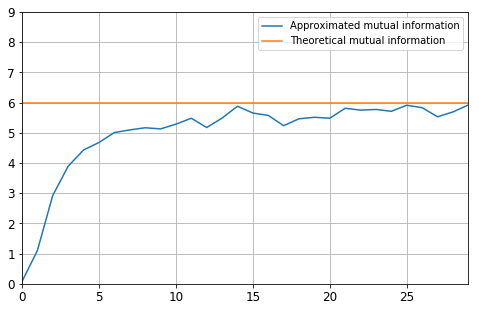

In [9]:
df_mi.plot(figsize=(8, 5))
plt.plot(history_range, true_mi, label='Theoretical mutual information')
plt.grid(True)
plt.gca().set_ylim(0, dim_n*3)
plt.legend()
#plt.tick_params(axis='x', colors='white')
#plt.tick_params(axis='y', colors='white')
plt.show()

## Encoder 

Input Dimension = M \\
Out Dimension = Channel Dimension = 2 * dim_n 

In [10]:
EncIn = tf.keras.layers.Input(shape=(M,))#, dtype= tf.int32)
e1 = tf.keras.layers.Dense(dim_n, activation=None)
e2 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
EncOut = tf.keras.layers.Lambda(lambda x: x/tf.sqrt(2*tf.reduce_mean(tf.square(x))))
GenIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x,(tf.shape(x)[0],-1)))
#GenOut = tf.keras.layers.Lambda(generator)
DecIn = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,int(n/2),2]))
d1 = tf.keras.layers.Lambda(lambda x:tf.reshape(x, shape=[-1,n]))
d2 = tf.keras.layers.Dense(M, activation='relu')
DecOut = tf.keras.layers.Dense(M, activation='softmax')


encoder =tf.keras.models.Sequential([EncIn,e1])    #Ohne reshape
decoder =tf.keras.models.Sequential([d2,DecOut]) # Ohne reshape

encoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 3)                 15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


### MI - Loss

m = Massege
x = AE(m)
y = Channel(x)

Loss = MI(x,y)

In [11]:
#MI_mod.trainable = False

MI_mod.summary()

def MI_loss(x,y):
  loss = -MI_mod([x,y])
  return loss




def real_channel(x):
    # Black-box Channel
    #AWGN
    return x + np.random.normal(0., np.sqrt(SIGNAL_NOISE), [SAMPLE_SIZE, dim_n])
  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1)            1171        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Exp (TensorFlowOpLa [(None, 1)]          0           sequential[1][0]             

## Training Function

In [0]:
#@tf.function
def train_step(m): #epoch, steps_per_epoches , batch_size, generator, discriminator):
    with tf.GradientTape() as enc_tape:
      x = encoder(m, training = True)
      y = real_channel(x)
      
      tf.print(x.shape)
      tf.print(y.shape)
      
      x_sample1, x_sample2 = tf.split(x, num_or_size_splits=2)
      y_sample1, y_sample2 = tf.split(y, num_or_size_splits=2)
      joint_sample = tf.concat([x_sample1, y_sample1], axis=1)
      marg_sample = tf.concat([x_sample2, y_sample1], axis=1)
      
      
      
      
      enc_loss = MI_loss((joint_sample, marg_sample), x)
      
      #tf.print(disc_loss,gen_loss)
      
      if tf.math.is_nan(enc_loss) == False:
        gradients_of_encoder = disc_tape.gradient(enc_loss, encoder.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_encode, encoder.trainable_variables))

### Trainings Data

In [0]:
def generate_data_vector(length):
  random_vector = tf.random.uniform(shape =(length,),minval=0,maxval=M, dtype=tf.dtypes.int32 ,seed=None,name=None)
  random_hot_one_vector = tf.one_hot(random_vector, depth=M,on_value=1, off_value=0,axis=-1)
  tf.print(random_hot_one_vector.shape)
  return random_hot_one_vector

#data, test_data = generate_data_vector(10000000), generate_data_vector(10000)


In [0]:
epochs = 500
batch_size = SAMPLE_SIZE

In [0]:
def train(epochs, batch_size):
  start = time.time()
  counter = 0
  epoch = 0
  m = generate_data_vector(batch_size)
  for epoch in range(epochs):
    counter += 1
    train_step(m)
    if counter%100 == 0:
    #print ('Time for epoch {} is {} sec,'.format(epoch + 1, time.time()-start))
      tf.print ('Time for epoch {},'.format(epoch + 1))
      
  #tf.saved_model.save(encoder,'/tmp/saved_model/')
  #tf.print ('Time for the training is {} sec,'.format( time.time()-start))

In [16]:
%%time
train(epochs , batch_size)
encoder.summary()

TensorShape([18000, 4])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([18000, 3])
TensorShape([180